# Day33 (2025-08-06)
- 모델 튜닝(GridSearchCV, RandomizedSearchCV)

1. 데이터 생성

In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit  # 시그모이드

np.random.seed(42)
n = 2000

# Step 1: 기본 변수 생성
df = pd.DataFrame({
    '성별': np.random.choice(['남', '여'], size=n),
    '나이': np.random.randint(20, 80, size=n),
    '수축기혈압': np.random.normal(125, 15, size=n).astype(int),
    '이완기혈압': np.random.normal(80, 10, size=n).astype(int),
    '공복혈당': np.random.normal(100, 20, size=n).astype(int),
    '총콜레스테롤': np.random.normal(200, 30, size=n).astype(int),
    '흡연여부': np.random.choice([0, 1], size=n, p=[0.7, 0.3]),
    '음주빈도': np.random.poisson(2, size=n),
    '운동빈도': np.random.poisson(3, size=n),
    'BMI': np.round(np.random.normal(24, 3, size=n), 1),
    '간수치': np.random.normal(35, 10, size=n).astype(int)
})

# Step 2: 위험점수 계산 (비선형 + 상호작용 + 노이즈)
risk_score = (
    0.04 * (df['나이'] ** 1.1) +
    0.06 * np.log1p(df['공복혈당']) +
    0.07 * (df['총콜레스테롤'] / 200) ** 1.5 +
    0.12 * df['BMI'] * df['흡연여부'] +
    0.1 * (df['수축기혈압'] > 140).astype(int) +
    0.08 * (df['간수치'] > 50).astype(int) +
    0.1 * (df['운동빈도'] < 2).astype(int) +
    0.03 * df['음주빈도'] +
    0.02 * (df['성별'] == '남').astype(int) +
    np.random.normal(0, 5, size=n)  # 현실 노이즈 추가
)

# Step 3: 시그모이드 함수로 확률화 + 이진화
risk_prob = expit((risk_score - 6) / 2)  # 기준값 조정
df['심혈관질환위험'] = np.where(np.random.rand(n) < risk_prob, 1, 0)

df['성별코드']=df['성별'].map({'남' : 0, '여' : 1})

2. 모델 학습

In [4]:
X=df.drop(['심혈관질환위험', '성별'], axis=1)
y=df['심혈관질환위험']

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

logi = LogisticRegression()
logi.fit(X_train_scaled, y_train)

rf=RandomForestClassifier(random_state=42)
dt=DecisionTreeClassifier(random_state=42)
xgb=XGBClassifier(random_state=42, use_label_encoder=False, eval_metrics='logloss')

rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
xgb.fit(X_train, y_train)

c:\Users\kgh44\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:54:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


3. 성능평가 함수 제작

In [3]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', family='Malgun Gothic')

def evaluate(name, model):
    y_pred=model.predict(X_test)
    y_proba=model.predict_proba(X_test)[:, 1]

    print(f'{name} 성능 지표')
    print('confussion matrix \n', confusion_matrix(y_test, y_pred))
    print('f1 score :', f1_score(y_test, y_pred))
    print('AUC :', roc_auc_score(y_test, y_proba))
    print('classification report \n', classification_report(y_test, y_pred))

    precisions, recalls, threshold=precision_recall_curve(y_test, y_proba)
    plt.plot(threshold, precisions[:-1], 'b--', label='정밀도')
    plt.plot(threshold, recalls[:-1], 'g-', label='재현율')
    plt.xlabel('Threshold')
    plt.ylabel('score')
    plt.title(f'{name} 정밀도 vs 재현율 트레이드오프')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def evaluate_logi(logi):
    y_pred=logi.predict(X_test_scaled)
    y_proba=logi.predict_proba(X_test_scaled)[:, 1]

    print('로지스틱 회귀 성능 지표')
    print('confussion matrix \n', confusion_matrix(y_test, y_pred))
    print('f1 score :', f1_score(y_test, y_pred))
    print('AUC :', roc_auc_score(y_test, y_proba))
    print('classification report \n', classification_report(y_test, y_pred))

    precisions, recalls, threshold=precision_recall_curve(y_test, y_proba)
    plt.plot(threshold, precisions[:-1], 'b--', label='정밀도')
    plt.plot(threshold, recalls[:-1], 'g-', label='재현율')
    plt.xlabel('Threshold')
    plt.ylabel('score')
    plt.title('로지스틱 회귀 정밀도 vs 재현율 트레이드오프')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


4. 기존 모델 성능 평가

로지스틱 회귀 성능 지표
confussion matrix 
 [[200  28]
 [142  30]]
f1 score : 0.2608695652173913
AUC : 0.5792788657690738
classification report 
               precision    recall  f1-score   support

           0       0.58      0.88      0.70       228
           1       0.52      0.17      0.26       172

    accuracy                           0.57       400
   macro avg       0.55      0.53      0.48       400
weighted avg       0.56      0.57      0.51       400



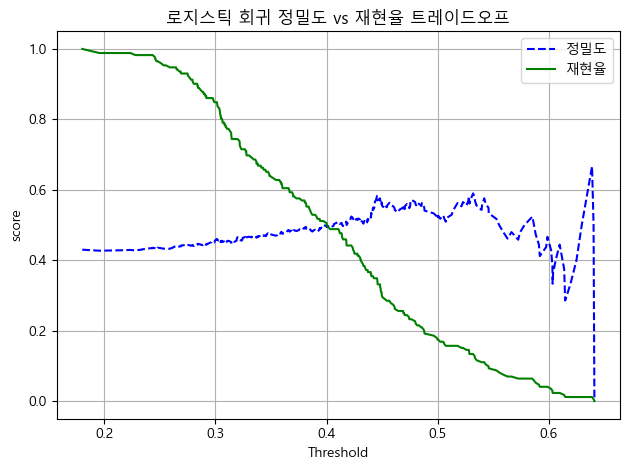

랜덤포레스트 성능 지표
confussion matrix 
 [[182  46]
 [130  42]]
f1 score : 0.3230769230769231
AUC : 0.5439743982048144
classification report 
               precision    recall  f1-score   support

           0       0.58      0.80      0.67       228
           1       0.48      0.24      0.32       172

    accuracy                           0.56       400
   macro avg       0.53      0.52      0.50       400
weighted avg       0.54      0.56      0.52       400



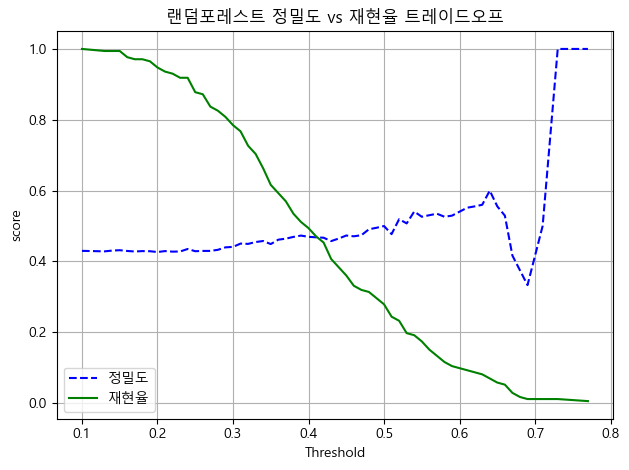

결정트리 성능 지표
confussion matrix 
 [[137  91]
 [100  72]]
f1 score : 0.4298507462686567
AUC : 0.5097409220726234
classification report 
               precision    recall  f1-score   support

           0       0.58      0.60      0.59       228
           1       0.44      0.42      0.43       172

    accuracy                           0.52       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.52      0.52      0.52       400



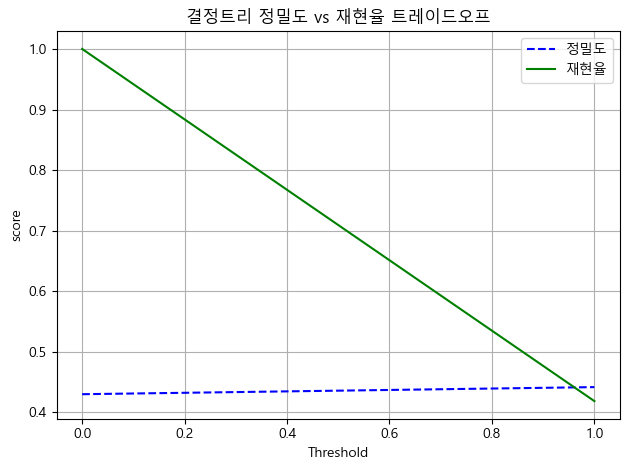

XGBoost 성능 지표
confussion matrix 
 [[165  63]
 [117  55]]
f1 score : 0.3793103448275862
AUC : 0.5501325989392085
classification report 
               precision    recall  f1-score   support

           0       0.59      0.72      0.65       228
           1       0.47      0.32      0.38       172

    accuracy                           0.55       400
   macro avg       0.53      0.52      0.51       400
weighted avg       0.53      0.55      0.53       400



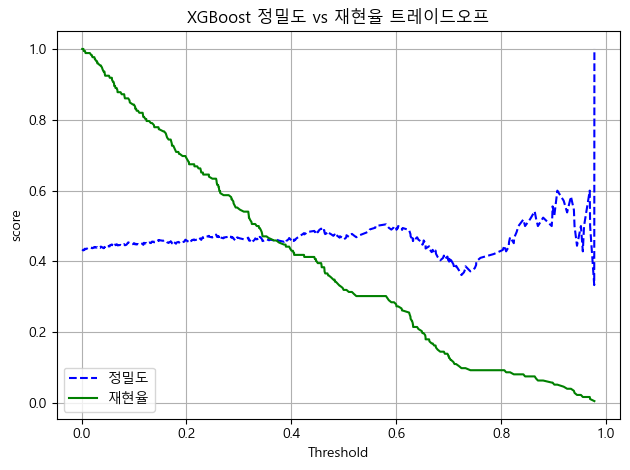

In [5]:
evaluate_logi(logi)
evaluate('랜덤포레스트', rf)
evaluate('결정트리', dt)
evaluate('XGBoost', xgb)

5. GridSearchCV
- “하이퍼파라미터를 ‘그리드(격자)’처럼 조합해서 전수조사하고, 그 중 제일 성능 좋은 조합을 찾아주는 애".

In [6]:
param_rf = {
    'n_estimators':[100,200,300],
    'max_depth' : [5,10,15],
    'min_samples_split' : [2,5],
    'min_samples_leaf' : [1,2,3]
}

grid_rf = GridSearchCV(rf, param_rf, cv=3, scoring='recall', n_jobs=-1)
#랜덤포레스트 모델을 f1-score기준으로 param_rf에 있는 모든 하이퍼파라미터 조합을 3-Fold교착검증으로 돌려보고 그 중 제일 f1좋은 조합 뽑기
grid_rf.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5], 'n_estimators': [100, 200, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


튜닝 랜덤포레스트 성능 지표
confussion matrix 
 [[187  41]
 [132  40]]
f1 score : 0.31620553359683795
AUC : 0.5348582211342309
classification report 
               precision    recall  f1-score   support

           0       0.59      0.82      0.68       228
           1       0.49      0.23      0.32       172

    accuracy                           0.57       400
   macro avg       0.54      0.53      0.50       400
weighted avg       0.55      0.57      0.53       400



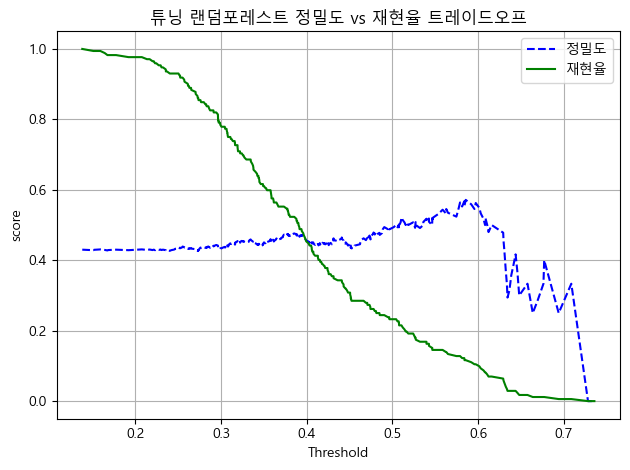

랜덤포레스트 성능 지표
confussion matrix 
 [[182  46]
 [130  42]]
f1 score : 0.3230769230769231
AUC : 0.5439743982048144
classification report 
               precision    recall  f1-score   support

           0       0.58      0.80      0.67       228
           1       0.48      0.24      0.32       172

    accuracy                           0.56       400
   macro avg       0.53      0.52      0.50       400
weighted avg       0.54      0.56      0.52       400



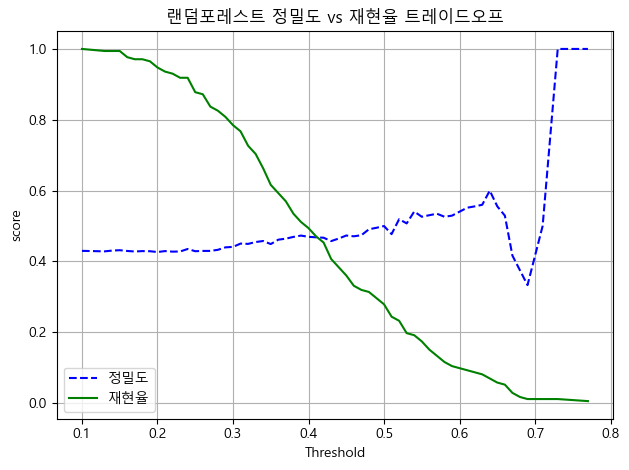

In [7]:
evaluate('튜닝 랜덤포레스트', grid_rf)
evaluate('랜덤포레스트', rf)

6. RandomizedSearchCV

In [8]:
param_xgb = {
    'n_estimators':[100,200],
    'max_depth' : [3,4,5],
    'learning_rate' : [0.01, 0.1, 0.3],
    'subsample' :[0.7, 1],
    'colsample_bytree' :[0.7, 1]
}

rand_xgb=RandomizedSearchCV(xgb, param_xgb, cv=3, scoring='recall', n_iter=10, n_jobs=-1, random_state=42)
rand_xgb.fit(X_train, y_train)

c:\Users\kgh44\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:00:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...obs=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 1], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200], ...}"
,n_iter,10
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


튜닝 xgboost 성능 지표
confussion matrix 
 [[165  63]
 [110  62]]
f1 score : 0.4175084175084175
AUC : 0.5832058343533252
classification report 
               precision    recall  f1-score   support

           0       0.60      0.72      0.66       228
           1       0.50      0.36      0.42       172

    accuracy                           0.57       400
   macro avg       0.55      0.54      0.54       400
weighted avg       0.56      0.57      0.55       400



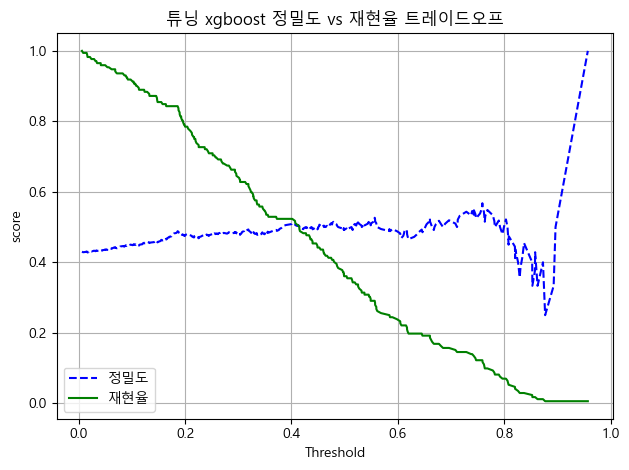

xgboost 성능 지표
confussion matrix 
 [[165  63]
 [117  55]]
f1 score : 0.3793103448275862
AUC : 0.5501325989392085
classification report 
               precision    recall  f1-score   support

           0       0.59      0.72      0.65       228
           1       0.47      0.32      0.38       172

    accuracy                           0.55       400
   macro avg       0.53      0.52      0.51       400
weighted avg       0.53      0.55      0.53       400



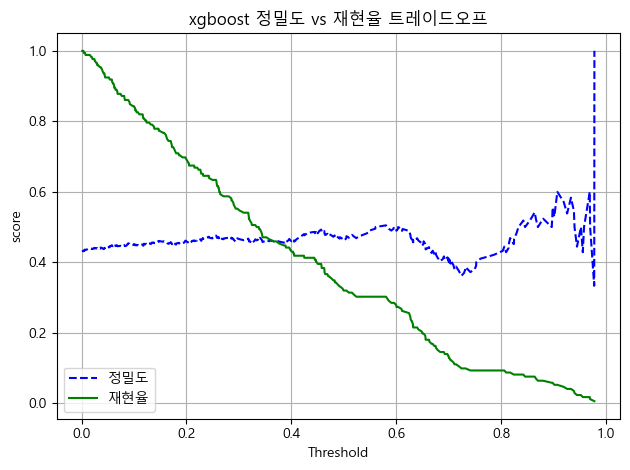

In [9]:
evaluate('튜닝 xgboost', rand_xgb)
evaluate('xgboost', xgb)

7. 최종 성능 평가 비교표

| 모델    | f1       | AUC  | Recall (1 class) |
| ----- | -------- | ---- | ---------------- |
| 기본 랜덤포레스트 | **0.32** | 0.54 | 0.24             |
| 튜닝 랜덤포레스트 | **0.31** | 0.53 | **0.23**    |


- recall이 약간 감소하고, AUC까지 하락했다. 즉, 모델이 과소적합되었음을 알 수 있다.
- 튜닝 방향이 잘못 되었을 것이다. 과도한 제약이 걸렸을 가능성이 높다.

| 모델    | f1       | AUC  | Recall (1 class) |
| ----- | -------- | ---- | ---------------- |
| 기본 XGBoost | **0.37** | 0.55 | 0.32             |
| 튜닝 XGBoost | **0.41** | 0.58 | **0.36**    |


- f1, auc, recall모두 상승하며 전반적으로 성능이 개선되었다.
- XGBoost가 이 문제에 잘 맞음을 알 수 있다.